In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the model
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Load the COVID and Normal data only
train_data = datasets.ImageFolder('/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/', transform=transform)

# Filter only COVID and Normal classes by class indices
class_to_idx = {'COVID': 0, 'Normal': 1}  # Binary class mapping
train_data.samples = [(path, label) for path, label in train_data.samples if label in class_to_idx.values()]

# Create DataLoader
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(train_data, batch_size=32, shuffle=False)


In [27]:
import torch.nn as nn
import torchvision.models as models

# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification (2 classes: COVID, Normal)
model.fc = nn.Linear(model.fc.in_features, 2)

# Move the model to the appropriate device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
from tqdm import tqdm

# Function to evaluate the model's performance on the test set
def evaluate(model, testloader, criterion):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate total loss
            total_loss += loss.item()

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(testloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop with tqdm and evaluation after each epoch
for epoch in range(2):  # Train for 5 epochs
    model.train()
    running_loss = 0.0
    train_progress = tqdm(trainloader, desc=f'Epoch [{epoch+1}/5]', leave=False)

    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        train_progress.set_postfix(loss=running_loss / (train_progress.n + 1))

    # Calculate training loss
    avg_train_loss = running_loss / len(trainloader)

    # Evaluate the model on the test set after each epoch
    test_loss, test_accuracy = evaluate(model, testloader, criterion)

    # Print the results for the current epoch
    print(f'Epoch [{epoch+1}/5], Training Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/5], Training Loss: 0.3916, Test Loss: 0.3275, Test Accuracy: 85.63%


Epoch [2/5], Training Loss: 0.3179, Test Loss: 0.2658, Test Accuracy: 87.97%


In [ ]:
pip install grad-cam

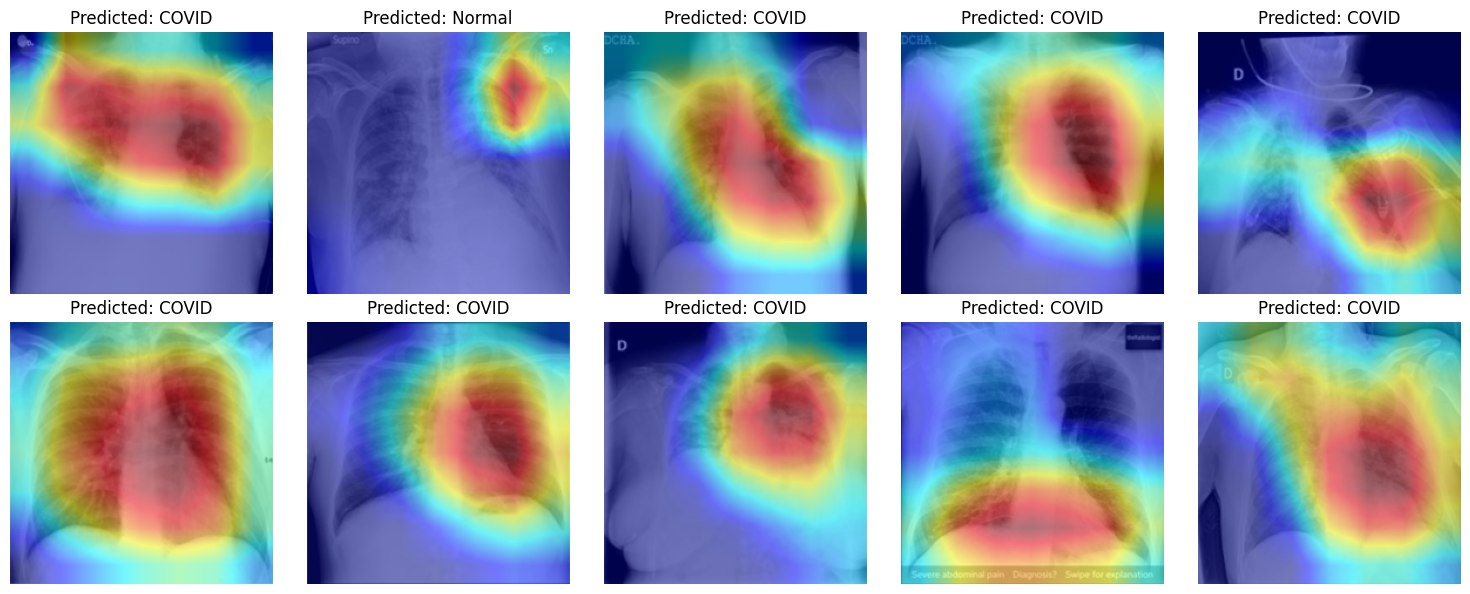

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set the target layers for Grad-CAM
target_layers = [model.layer4[-1]]

# Create a subplot figure for 10 images (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Set model to evaluation mode
model.eval()

# Counter to track the number of images processed
image_count = 0

# Loop through the test set
for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    # Forward pass to get predictions
    outputs = model(images)

    for i in range(min(10, len(images))):  # Ensure we process only 10 images
        # Get the predicted class for the current image
        pred_class = outputs[i].argmax(dim=0).item()

        # Create a Grad-CAM object
        with GradCAM(model=model, target_layers=target_layers) as cam:
            # Generate the Grad-CAM heatmap for the predicted class
            grayscale_cam = cam(input_tensor=images[i].unsqueeze(0), targets=[ClassifierOutputTarget(pred_class)])

            # In this case, grayscale_cam has only one image in the batch
            grayscale_cam = grayscale_cam[0]

            # Convert the input image to a format suitable for overlaying (HWC format)
            input_image = images[i].permute(1, 2, 0).cpu().numpy()
            input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalize to [0, 1]

            # Overlay the heatmap on the original image
            visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

            # Plot the Grad-CAM heatmap on the subplot
            ax = axes[image_count // 5, image_count % 5]  # Get the subplot axis
            ax.imshow(visualization)
            ax.set_title(f'Predicted: {"COVID" if pred_class == 0 else "Normal"}')
            ax.axis('off')

            image_count += 1

        if image_count == 10:
            break  # Stop after showing 10 images

    if image_count == 10:
        break  # Exit outer loop if 10 images are processed

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.3-py3-none-any.whl size=38657 sha256=f2530ab13a225fb48f7e760dca206a46996a82bc1a5e7fe72a28398b97a5d6f0
  Stored in directory: /root/.cache/pip/wheels/2e/ce/70/fe64f851895eae830b3c63ec7fc464cfa7c81aeb7ad4f68063
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.
